<a href="https://colab.research.google.com/github/SelimSavas/low-light-segmentation-with-mirnet-yolov8-segment-anything/blob/main/MIRNet-YOLOv8-Segment-Anything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv8 vs SAM Meta

## Library

In [1]:
!pip install ultralytics
!pip install supervision
!pip install roboflow

import numpy as np
import cv2
import os
import sys
import torch
from roboflow import Roboflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.2/562.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 15.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 11.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=bc3dbb11a90292b88f8d847a210472e49c95e860f29fd19dc08129baa0de9f9e
  Stored in directory: /root/.cache/

In [2]:
import random
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tensorflow import keras

# Özel kayıp işlevini yeniden tanımlayın
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


# MirNet modelinizi yükleyin ve custom_objects argümanına özel kayıp işlevinizi geçin
mirnet_model = keras.models.load_model('/content/drive/MyDrive/mirnet_model.h5', custom_objects={'charbonnier_loss': charbonnier_loss,'peak_signal_noise_ratio':peak_signal_noise_ratio})


In [5]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [6]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ms9dg76o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ms9dg76o
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=faebc79d48e32368769d89d8aff30cdc0249ef6b2f74a73cc028ebc2614fd92e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvensiic/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [7]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_l"

In [8]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

/content
/content/weights


In [9]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_l_0b3195.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_l_0b3195.pth ; exist: True


In [11]:
low_light_image = Image.open('/content/dalton-smith-LXHwWziV3eg-unsplash.jpg')
image = low_light_image.resize((1400,1000),Image.NEAREST)
image = keras.preprocessing.image.img_to_array(image)
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis = 0)
image = mirnet_model.predict(image)
image = image[0] * 255.0
image = image.clip(0,255)
image = image.reshape((np.shape(image)[0],np.shape(image)[1],3))
image = np.uint32(image)

1/1 [==============================] - 31s 31s/step


In [12]:
image.shape

(1000, 1400, 3)

## YoloV8 - Creating BBox

In [13]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8x.pt')

results = yolo_model.predict(source=image.astype(np.uint8))

boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))

100%|██████████| 131M/131M [00:01<00:00, 131MB/s]

0: 480x640 4 cars, 134.8ms
Speed: 28.8ms preprocess, 134.8ms inference, 24.9ms postprocess per image at shape (1, 3, 640, 640)


In [14]:
boxes

array([[     619.64,      565.09,      1259.5,       852.7],
       [     335.81,      579.51,      731.07,      797.03],
       [     166.86,      572.67,      475.74,      790.34],
       [     1106.2,      581.51,      1399.1,      762.37]])

## SAM - Segmentation

In [15]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import supervision as sv

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

mask_predictor = SamPredictor(sam)

In [21]:
image = image.astype(np.uint8)
segmented_image = image.copy()
box_image = image.copy()
boxes_class_value = {'0':sv.Color.white(),'2':sv.Color.blue(),'4':sv.Color.red(),'5':sv.Color.blue() ,'7':sv.Color.black(),'8':sv.Color.green()}
mask_predictor.set_image(image)

boxes = result.boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([4, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7fe5043dffb0>
tensor([[ 619.6430,  565.0890, 1259.5042,  852.6966],
        [ 335.8108,  579.5139,  731.0747,  797.0259],
        [ 166.8627,  572.6707,  475.7360,  790.3434],
        [1106.1666,  581.5126, 1399.0787,  762.3709]], device='cuda:0')


In [22]:
boxes.shape[0]

4

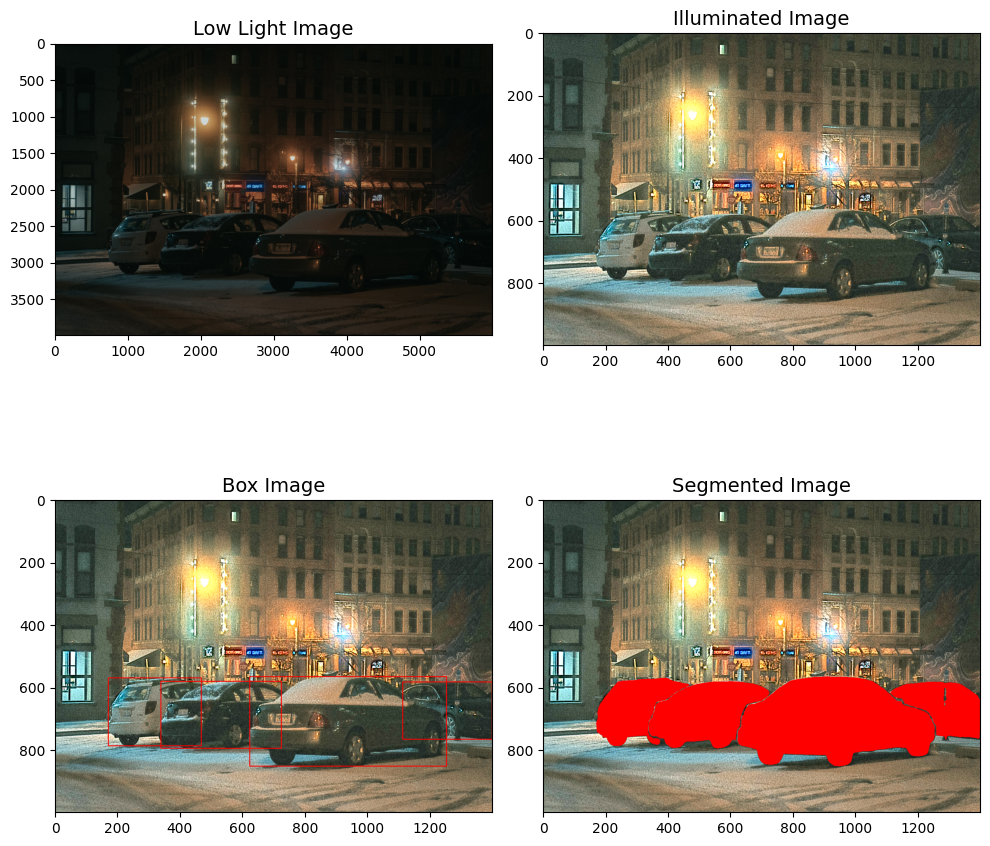

In [39]:
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(image.shape),
    multimask_output=True
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )
    
    detections = detections[detections.area == np.max(detections.area)]
    box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)
    i += 1

# Görüntülerinizi ayrı ayrı birer dizi olarak saklayın
images = [low_light_image, image, box_image, segmented_image]

# Başlık dizisi oluşturun
titles = ['Low Light Image', 'Illuminated Image', 'Box Image', 'Segmented Image']

# Görüntülerinizi 2x2 bir ızgara içinde gösterin
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.set_title(titles[idx], fontsize=14)
    else:
        ax.axis('off')
plt.tight_layout()
plt.show()